# Audio Data Augmentation

In [14]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.1.0
2.1.0


## Preparation

In [15]:
from IPython.display import Audio

from torchaudio.utils import download_asset

# VIVOSDEV01_R002 TIẾNG CỌC CẠCH KHỰNG LẠI CỦA NHỮNG KHỚP SẮT
SAMPLE_WAV = "datasets/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R002.wav"
# SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")

SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

## Apply effects and filtering

In [16]:
# Load the data
waveform1, sample_rate = torchaudio.load(SAMPLE_WAV, channels_first=False)

# Define effects
effect = ",".join(
    [
        "lowpass=frequency=300:poles=1",  # apply single-pole lowpass filter
        "atempo=0.8",  # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)

# Apply effects
def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)


waveform2 = apply_effect(waveform1, sample_rate, effect)
print(waveform1.shape, sample_rate)
print(waveform2.shape, sample_rate)

torch.Size([65000, 1]) 16000
torch.Size([84066, 1]) 16000


In [17]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

### Original

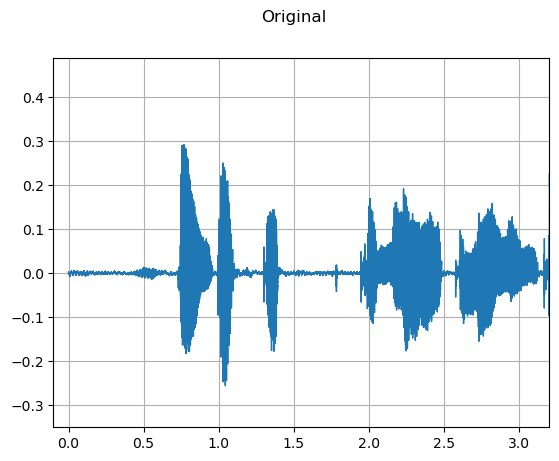

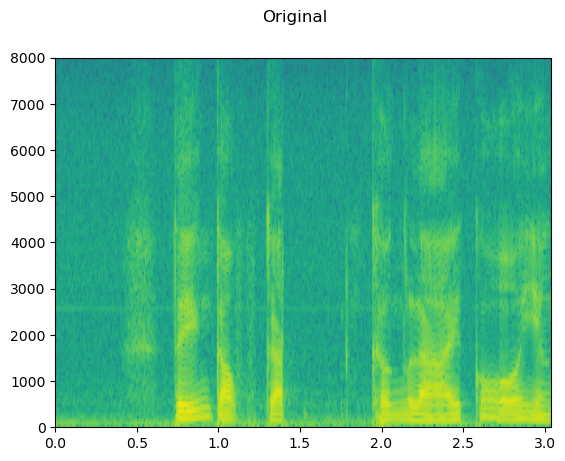

In [18]:
plot_waveform(waveform1.T, sample_rate, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1.T, sample_rate, title="Original", xlim=(0, 3.04))
Audio(waveform1.T, rate=sample_rate)

### Effects applied

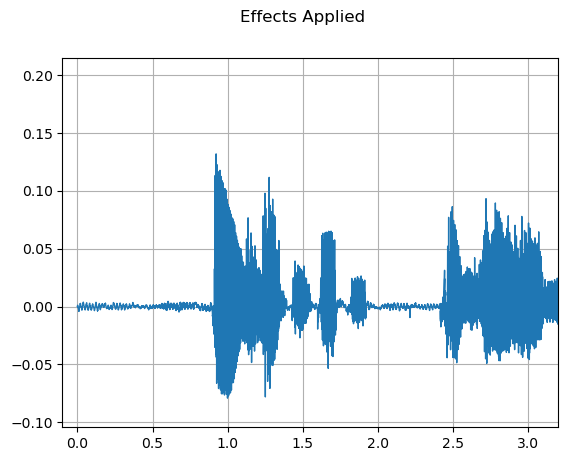

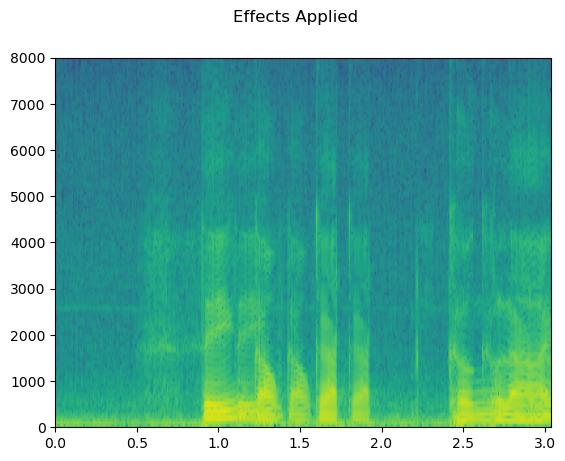

In [19]:
plot_waveform(waveform2.T, sample_rate, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2.T, sample_rate, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform2.T, rate=sample_rate)

## Simulating room reverberation - Mô phỏng tiếng vang trong phòng

Reverb tích chập là một kỹ thuật được sử dụng để tạo ra âm thanh trong trẻo như thể nó được tạo ra trong một môi trường khác.

Ví dụ: bằng cách sử dụng Phản hồi xung trong phòng (RIR), chúng ta có thể tạo ra âm thanh giọng nói rõ ràng như thể nó được phát ra trong phòng hội thảo.

Đối với quá trình này, chúng tôi cần dữ liệu RIR. Dữ liệu sau đây được lấy từ tập dữ liệu VOiCES nhưng bạn có thể ghi âm dữ liệu của riêng mình - chỉ cần bật micrô và vỗ tay.

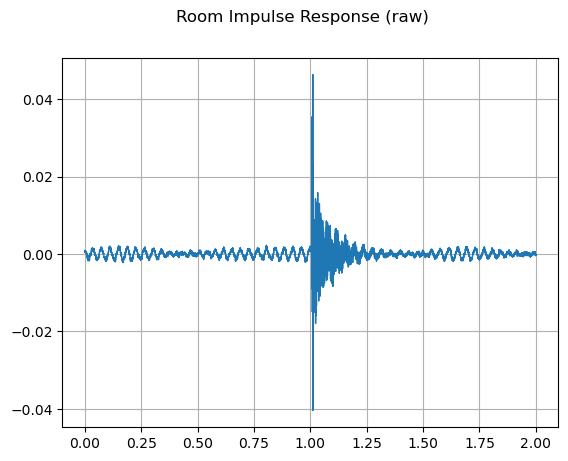

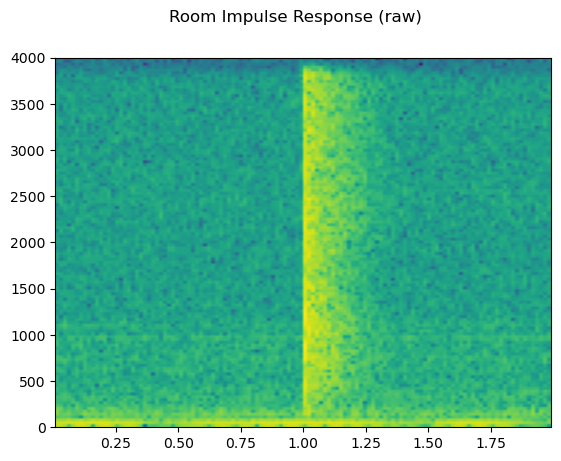

In [20]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

Đầu tiên, chúng ta cần dọn sạch RIR. Chúng tôi trích xuất xung lực chính và bình thường hóa nó bằng sức mạnh của nó.

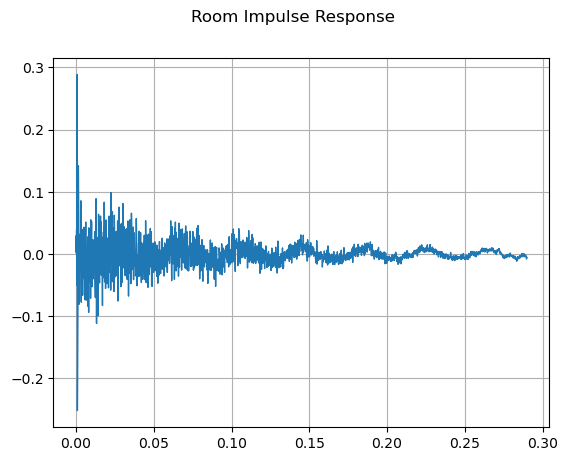

In [21]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)

plot_waveform(rir, sample_rate, title="Room Impulse Response")

Sau đó, bằng cách sử dụng `torchaudio.functional.fftconvolve()`, chúng tôi kết hợp tín hiệu giọng nói với RIR.

In [22]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
augmented = F.fftconvolve(speech, rir)

### Original

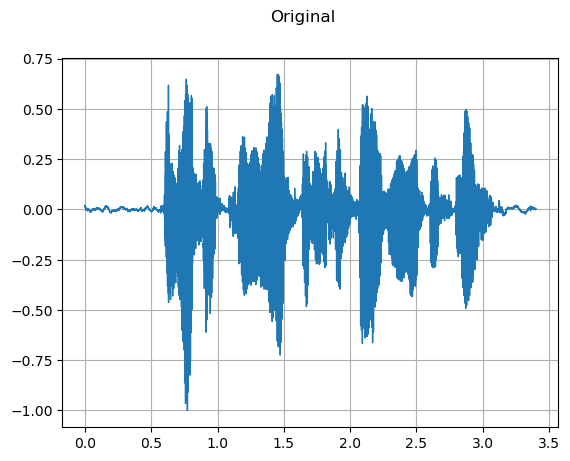

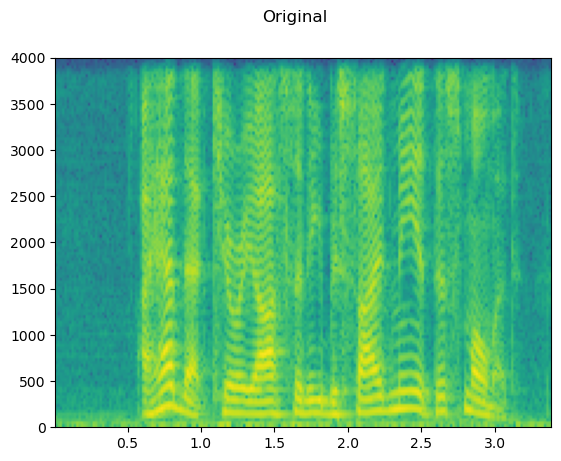

In [23]:
plot_waveform(speech, sample_rate, title="Original")
plot_specgram(speech, sample_rate, title="Original")
Audio(speech, rate=sample_rate)

### RIR applied


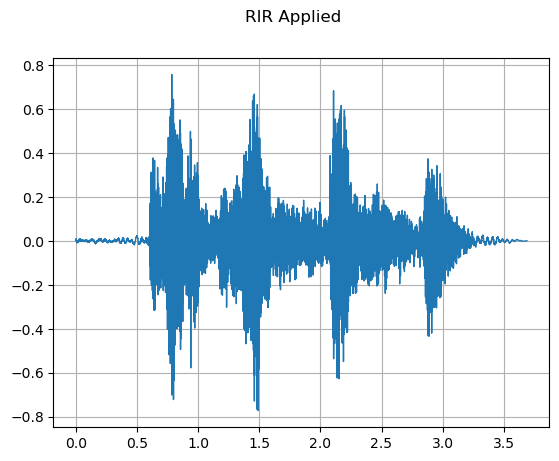

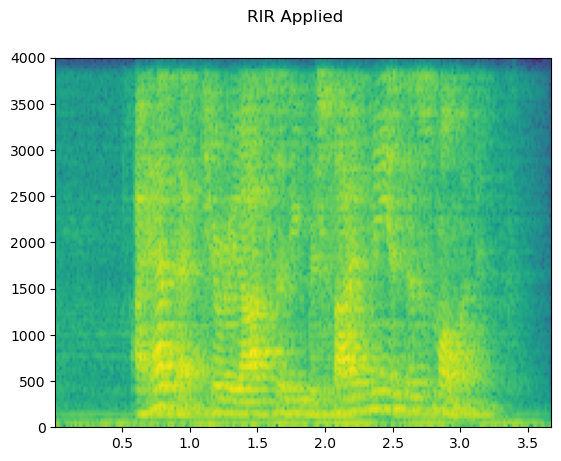

In [24]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
plot_specgram(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

## Adding background noise

Để đưa nhiễu nền vào dữ liệu âm thanh, chúng ta có thể thêm Tensor nhiễu vào Tensor biểu thị dữ liệu âm thanh theo một số mong muốn 

Tỷ lệ tín hiệu trên nhiễu (SNR), xác định cường độ của dữ liệu âm thanh so với cường độ của nhiễu ở đầu ra.
 
​


In [25]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : speech.shape[1]]

snr_dbs = torch.tensor([20, 10, 3])
noisy_speeches = F.add_noise(speech, noise, snr_dbs)

### Background noise


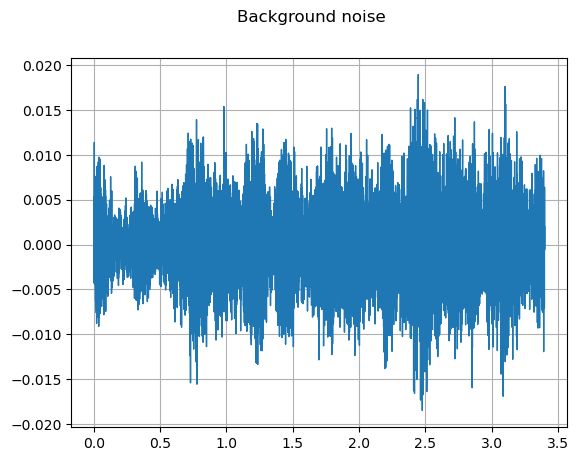

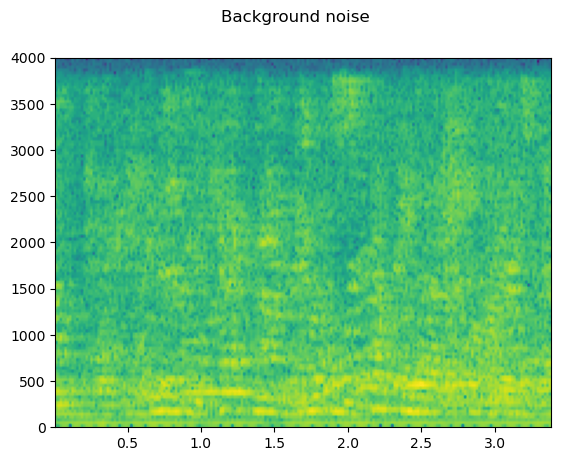

In [26]:
plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
Audio(noise, rate=sample_rate)

### SRN 20 db

Signal-to-noise ratio (SNR) 

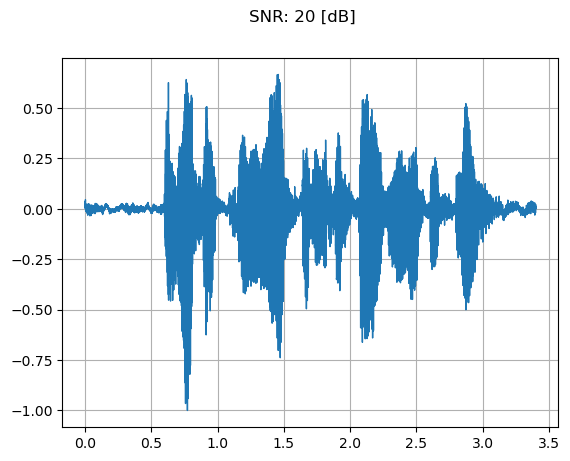

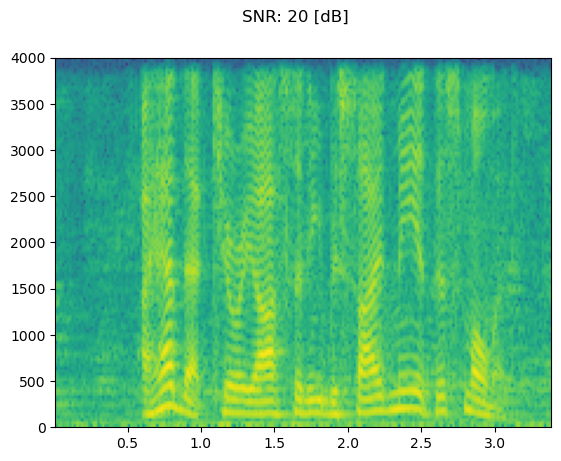

In [27]:
snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0:1]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 10 dB

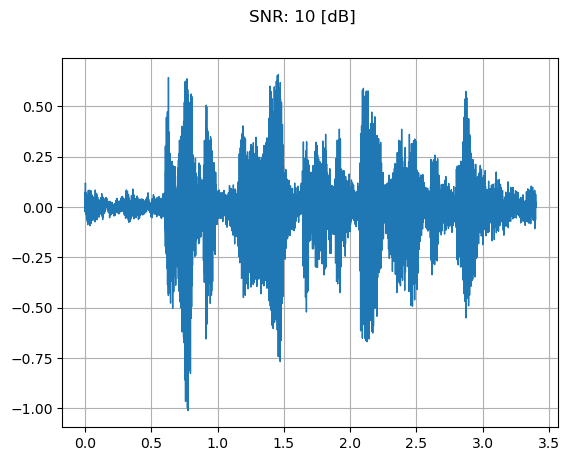

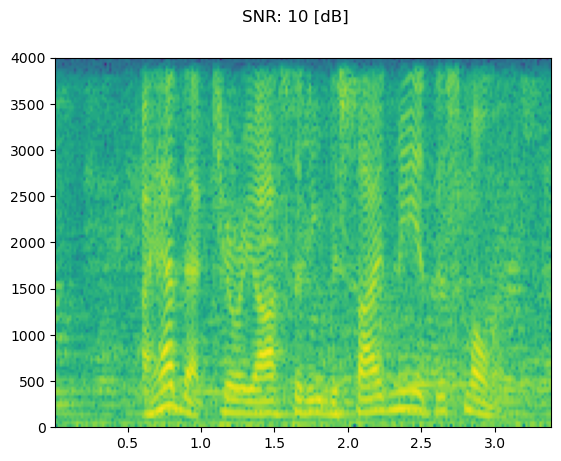

In [28]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1:2]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 3 dB

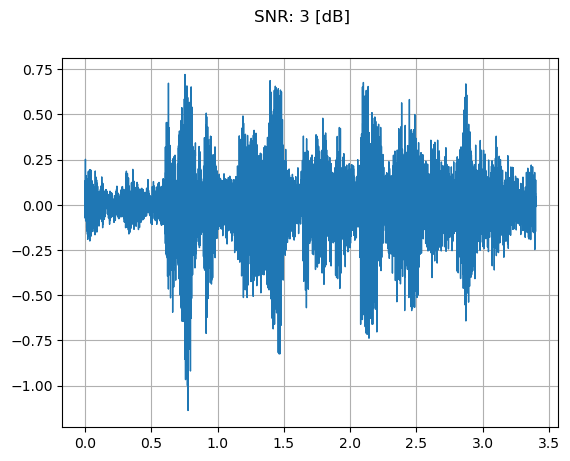

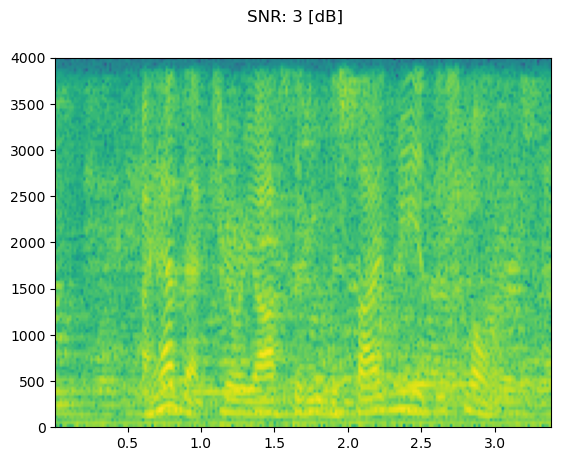

In [29]:
snr_db, noisy_speech = snr_dbs[2], noisy_speeches[2:3]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

## Applying codec to Tensor object

`torchaudio.io.AudioEffector` can also apply codecs to a Tensor object.

In [30]:
waveform, sample_rate = torchaudio.load(SAMPLE_SPEECH, channels_first=False)

def apply_codec(waveform, sample_rate, format, encoder=None):
    encoder = torchaudio.io.AudioEffector(format=format, encoder=encoder)
    return encoder.apply(waveform, sample_rate)

### Original

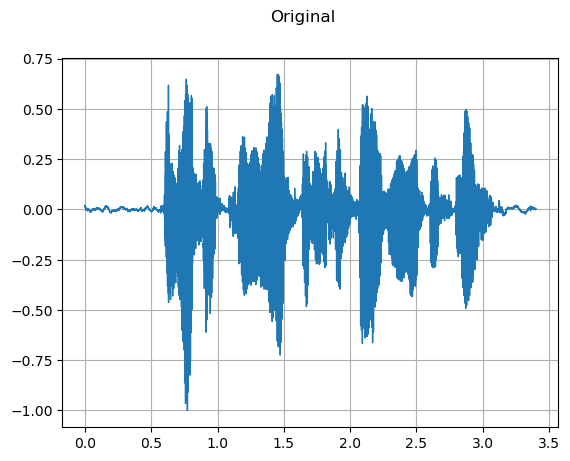

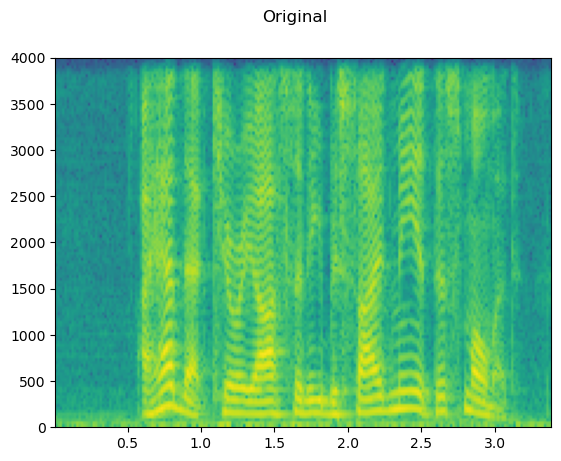

In [31]:
plot_waveform(waveform.T, sample_rate, title="Original")
plot_specgram(waveform.T, sample_rate, title="Original")
Audio(waveform.T, rate=sample_rate)

### 8 bit mu-law

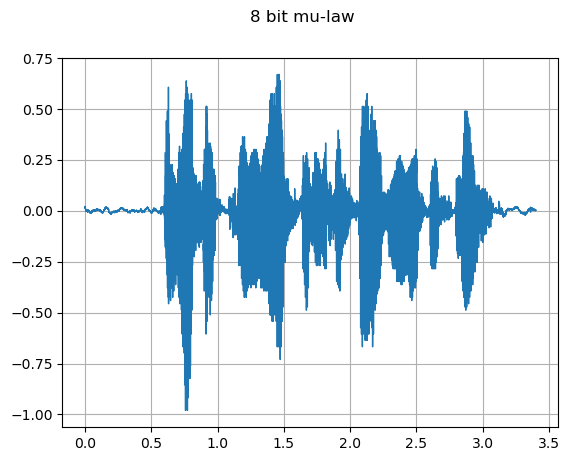

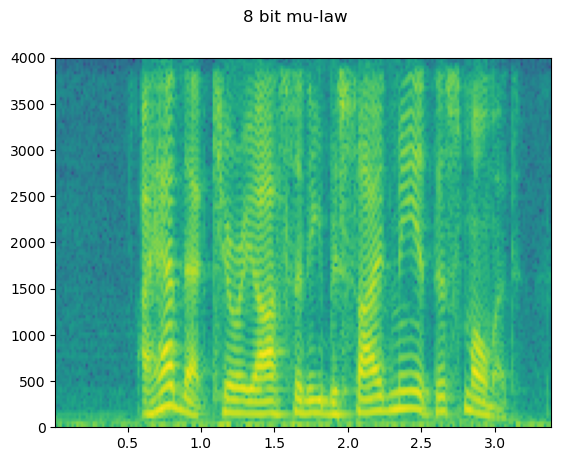

In [32]:
mulaw = apply_codec(waveform, sample_rate, "wav", encoder="pcm_mulaw")
plot_waveform(mulaw.T, sample_rate, title="8 bit mu-law")
plot_specgram(mulaw.T, sample_rate, title="8 bit mu-law")
Audio(mulaw.T, rate=sample_rate)

### G.722

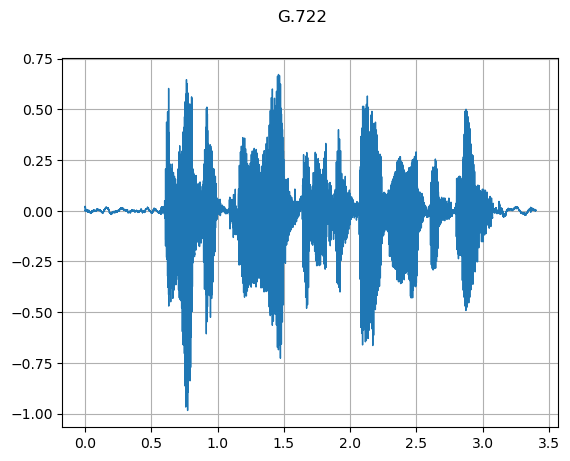

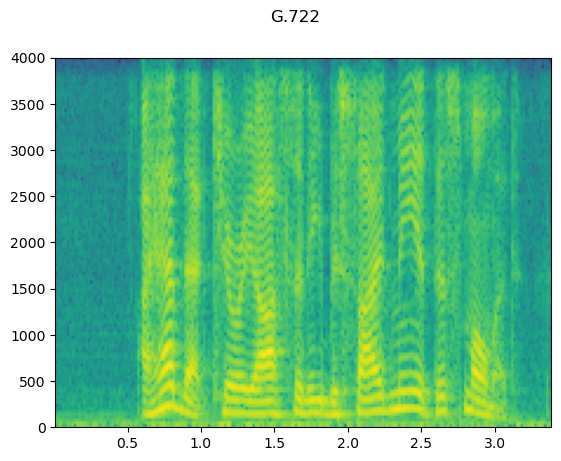

In [33]:
g722 = apply_codec(waveform, sample_rate, "g722")
plot_waveform(g722.T, sample_rate, title="G.722")
plot_specgram(g722.T, sample_rate, title="G.722")
Audio(g722.T, rate=sample_rate)

### Vorbis

[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())
/home/mpp/miniconda3/envs/audio/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


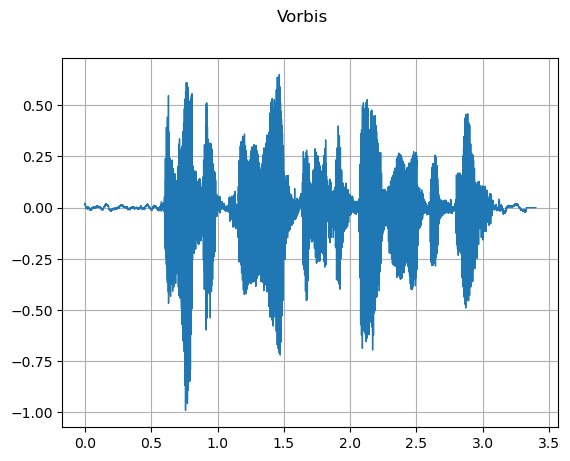

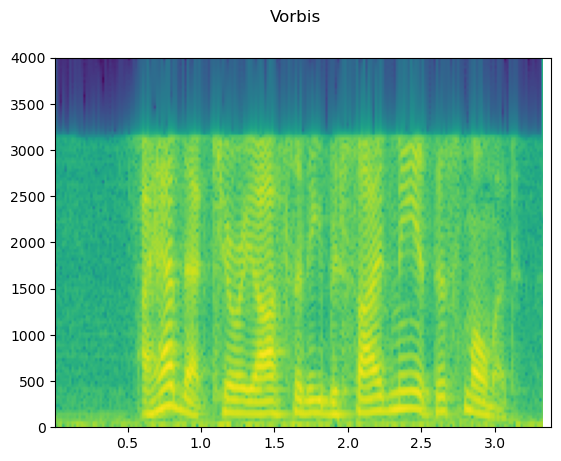

In [34]:
vorbis = apply_codec(waveform, sample_rate, "ogg", encoder="vorbis")
plot_waveform(vorbis.T, sample_rate, title="Vorbis")
plot_specgram(vorbis.T, sample_rate, title="Vorbis")
Audio(vorbis.T, rate=sample_rate)

## Simulating a phone recoding

Kết hợp các kỹ thuật trước đó, chúng ta có thể mô phỏng âm thanh giống như một người đang nói chuyện qua điện thoại trong phòng có tiếng vang với những người đang nói chuyện ở phía sau.


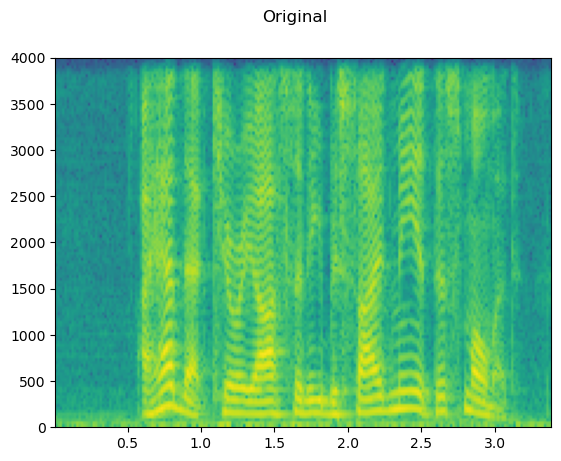

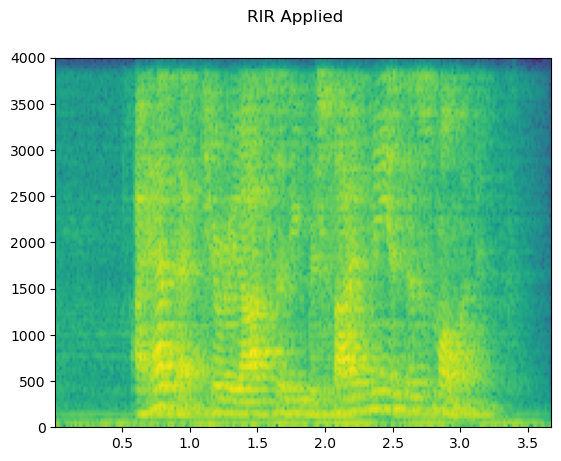

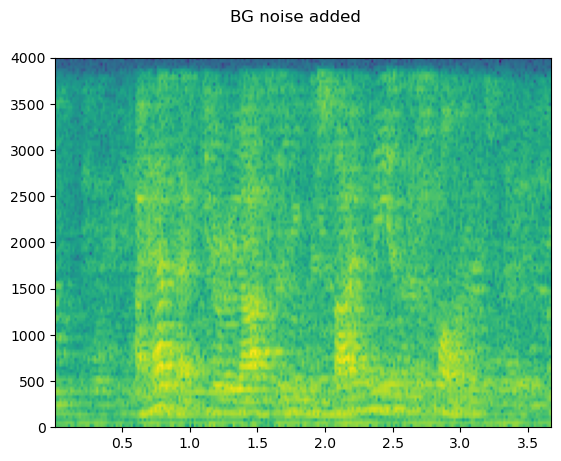

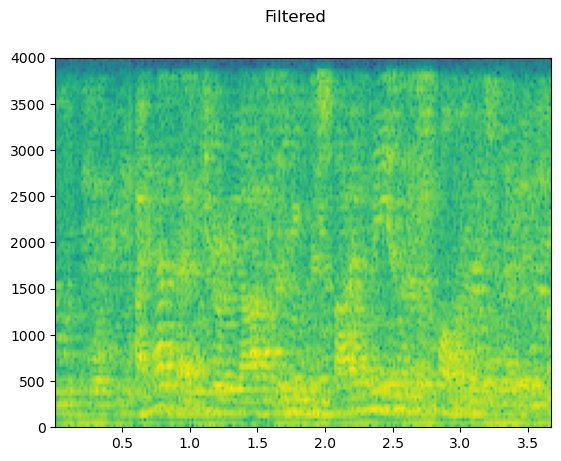

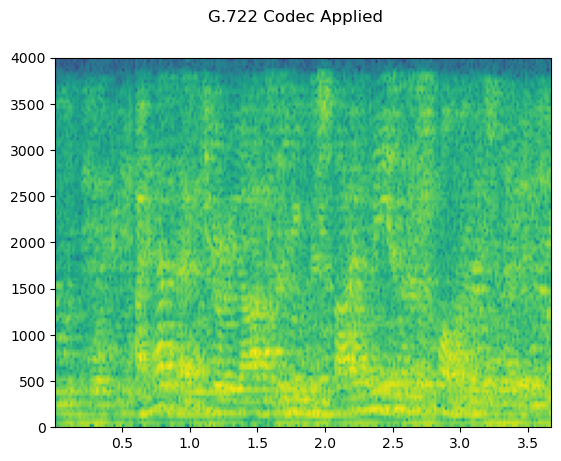

In [35]:
sample_rate = 16000
original_speech, sample_rate = torchaudio.load(SAMPLE_SPEECH)

plot_specgram(original_speech, sample_rate, title="Original")

# Apply RIR
rir_applied = F.fftconvolve(speech, rir)

plot_specgram(rir_applied, sample_rate, title="RIR Applied")

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : rir_applied.shape[1]]

snr_db = torch.tensor([8])
bg_added = F.add_noise(rir_applied, noise, snr_db)

plot_specgram(bg_added, sample_rate, title="BG noise added")

# Apply filtering and change sample rate
effect = ",".join(
    [
        "lowpass=frequency=4000:poles=1",
        "compand=attacks=0.02:decays=0.05:points=-60/-60|-30/-10|-20/-8|-5/-8|-2/-8:gain=-8:volume=-7:delay=0.05",
    ]
)

filtered = apply_effect(bg_added.T, sample_rate, effect)
sample_rate2 = 8000

plot_specgram(filtered.T, sample_rate2, title="Filtered")

# Apply telephony codec
codec_applied = apply_codec(filtered, sample_rate2, "g722")
plot_specgram(codec_applied.T, sample_rate2, title="G.722 Codec Applied")

### Original speech


In [36]:
Audio(original_speech, rate=sample_rate)

### RIR applied

In [37]:
Audio(rir_applied, rate=sample_rate)

### Background noise added

In [38]:
Audio(bg_added, rate=sample_rate)

### Filtered

In [39]:
Audio(filtered.T, rate=sample_rate2)

### Codec applied

In [41]:
Audio(codec_applied.T, rate=sample_rate2)